In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
with open('first_database.pkl', 'rb') as f:
    x,y = pickle.load(f)

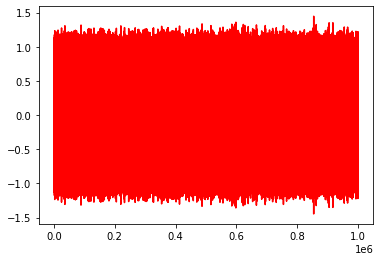

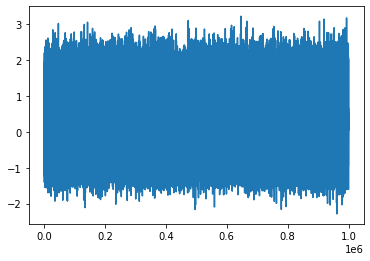

In [6]:
plt.plot(x, color='r')
plt.show()
plt.plot(y)
plt.show()

In [10]:
#Initialisation
n = 100
m = 10
a = 5
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = [x[i] for i in ind]
y_selected = [y[i] for i in ind]